In [13]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from typing import Literal

from fairdivision.experiments.notebooks.masters_thesis.xp_ece import get_random_tie_break_order, get_efx_preserving_agent, create_envy_graph, reallocate_bundles
from fairdivision.utils.agents import Agents
from fairdivision.utils.allocation import Allocation
from fairdivision.utils.generators import generate_agents, generate_items, generate_valuations, AdditiveGenerator, ValuationsGenerator
from fairdivision.utils.helpers import print_valuations
from fairdivision.utils.items import Items

In [14]:
def xp_ece(agents: Agents, items: Items, max_attempts: int = 1000) -> Allocation:
    """
    Returns an allocation for the given `agents` and `items`.

    While there are still unallocated items, it gives the favorite one to an agent that will certainly preserve the EFX
    property of the allocation. If more agents are preserving EFX, one is chosen according to a random priority order.
    Additionally, the algorithm uses an envy graph to redistribute bundles if no EFX-preserving agent is present. In
    case there are simultaneously no envy cycles and no agents preserving EFX property, the algorithm starts from
    scratch. A new tie-breaking order is randomly generated for every attempt to give an item, so each rerun of the
    algorithm may differ.
    """

    for stuck_count in range(max_attempts):
        items_left = items.copy()
        allocation = Allocation(agents)

        while items_left.size() > 0:
            tie_break_order = get_random_tie_break_order(agents)

            efx_preserving_agent = get_efx_preserving_agent(agents, items_left, tie_break_order, allocation)

            while efx_preserving_agent is None:
                envy_graph = create_envy_graph(agents, allocation)

                try:
                    cycle = nx.find_cycle(envy_graph)

                    reallocate_bundles(cycle, allocation)
                    efx_preserving_agent = get_efx_preserving_agent(agents, items_left, tie_break_order, allocation)
                except nx.NetworkXNoCycle:
                    break

            if efx_preserving_agent is None:
                break
            else:
                favorite_item = efx_preserving_agent.get_favorite_item(items_left)
                allocation.allocate(efx_preserving_agent, favorite_item)
                items_left.remove_item(favorite_item)
        else:
            return allocation, stuck_count

    print_valuations(agents, items)
    print()

    raise Exception("No EFX allocation found")

In [15]:
def get_stuck_counts(n, m, generator, iterations):
    stuck_counts = []

    for i in range(iterations):
        if i % 50000 == 0:
            print(i, end=" ")

        agents = generate_agents(n)
        items = generate_items(m)
        
        generate_valuations(agents, items, generator)

        allocation, stuck_count = xp_ece(agents, items)

        if stuck_count >= 1:
            stuck_counts.append(stuck_count)

    return stuck_counts


def draw_stuck(stuck_counts, title):
    bins = np.arange(0.5, max(stuck_counts) + 1.5, 1)

    plt.figure(figsize=(15, 6))
    
    tick_step = (max(stuck_counts) // 10) + 1
    max_tick = max(stuck_counts) // tick_step * (tick_step+1) + 1
    plt.xticks(np.arange(1, max_tick, tick_step))
    
    plt.hist(stuck_counts, bins=bins, color="navajowhite")

    plt.title(title)

    plt.xlabel("stuck count")
    plt.ylabel("number of instances")

    instances_per_stuck_count = dict()

    for stuck_count in stuck_counts:
        if stuck_count in instances_per_stuck_count:
            instances_per_stuck_count[stuck_count] += 1
        else:
            instances_per_stuck_count[stuck_count] = 1

    min_height = max(instances_per_stuck_count.values()) // 25
    
    for stuck_count in range(1, max(instances_per_stuck_count.keys()) + 1):
        if stuck_count in instances_per_stuck_count:
            plt.text(stuck_count, max(instances_per_stuck_count[stuck_count] // 2, min_height), instances_per_stuck_count[stuck_count], ha = 'center')
    
    plt.show()

### 5 agents and 9 items

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 500000 550000 600000 650000 700000 750000 800000 850000 900000 950000 

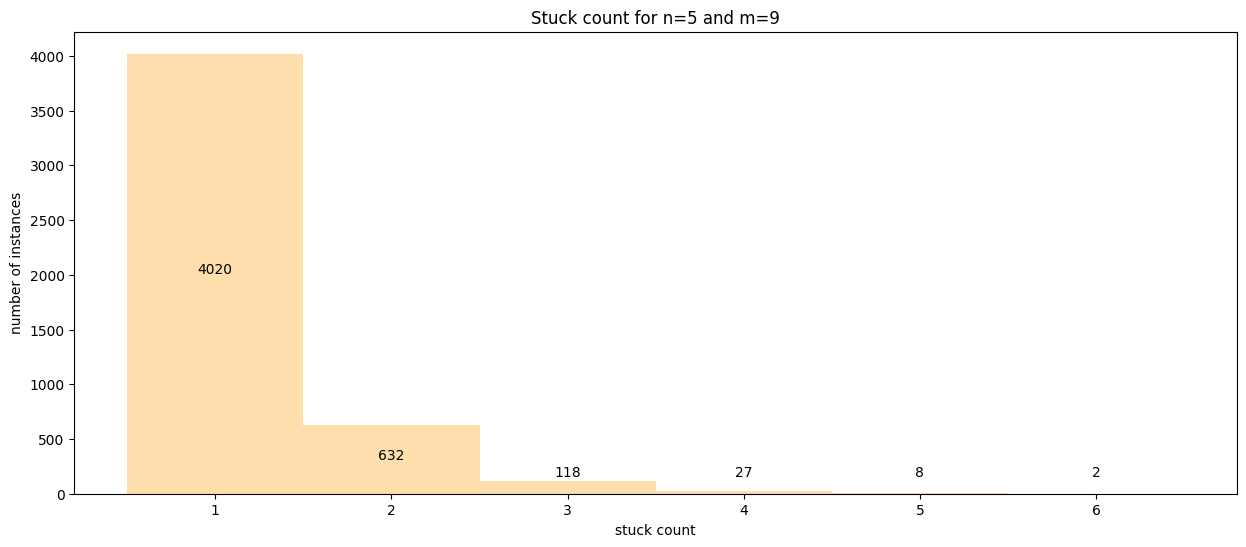

In [11]:
n = 5
m = 9
generator = AdditiveGenerator(min=0, max=10)
iterations = 1000000

stuck_counts = get_stuck_counts(n, m, generator, iterations)

draw_stuck(stuck_counts, "Stuck count for n=5 and m=9")

### 5 agents and 14 items

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 500000 550000 600000 650000 700000 750000 800000 850000 900000 950000 

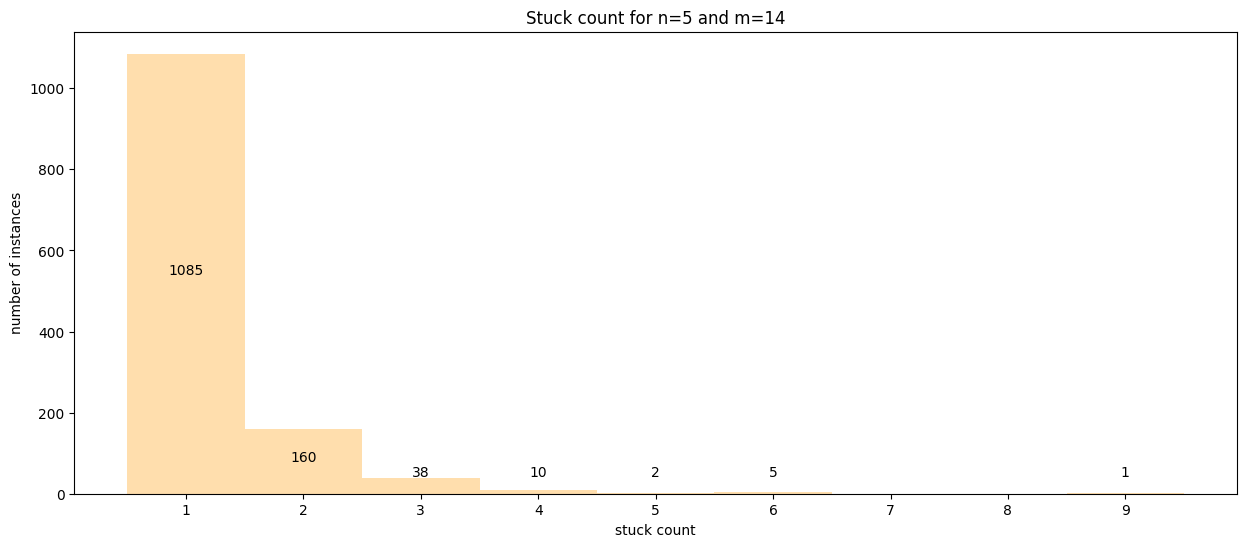

In [16]:
n = 5
m = 14
generator = AdditiveGenerator(min=0, max=10)
iterations = 1000000

stuck_counts = get_stuck_counts(n, m, generator, iterations)

draw_stuck(stuck_counts, "Stuck count for n=5 and m=14")